In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import datetime as dt
import math
from statistics import mean
from statistics import stdev
import warnings # Turn off warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot

# Imports

In [3]:
petition_df = pd.read_csv("~/data/sf-open-data/petitions-clean.csv") # 40749 rows
petition_df['Datetime'] = petition_df['Date'].apply(lambda x : dt.datetime.strptime(x, "%m/%d/%Y"))
petition_df['Timestamp'] = petition_df['Date'].apply(lambda x : mdates.datestr2num(x))

In [ ]:
unemployment_df = pd.read_csv("~/data/stlouisfed/CASANF0URN.csv") # 352 rows
unemployment_df = unemployment_df.rename(columns = {"CASANF0URN": "Rate"})
unemployment_df['Datetime'] = unemployment_df['DATE'].apply(lambda x : dt.datetime.strptime(x, "%Y-%m-%d"))
unemployment_df = unemployment_df.set_index("Datetime").drop(columns = "DATE")

# Neighborhood Number

In [4]:
# Collect all count results

petition_counts_by_neighborhood_df = petition_df[petition_df['Neighborhood Number'] == 1] \
    [['Petition ID Len', 'Datetime']] \
    .groupby(pd.TimeGrouper("M", key="Datetime")).count().rename(columns = {"Petition ID Len": 1})

for i in range(2, 27):
    petition_counts_by_neighborhood_df[i] = petition_df[petition_df['Neighborhood Number'] == i] \
        [['Petition ID Len', 'Datetime']] \
        .groupby(pd.TimeGrouper("M", key="Datetime")).count().fillna(0)
    
for i in range(28, 42):
    petition_counts_by_neighborhood_df[i] = petition_df[petition_df['Neighborhood Number'] == i] \
        [['Petition ID Len', 'Datetime']] \
        .groupby(pd.TimeGrouper("M", key="Datetime")).count().fillna(0)
    
petition_counts_by_neighborhood_df

,1,2,3,4,5,6,7,8,9,10,...,32,33,34,35,36,37,38,39,40,41
Datetime,,,,,,,,,,,,,,,,,,,,,
1997-01-31,2,5,6,NaN,6,NaN,1,1,7,NaN,...,6,NaN,1.0,5,13,NaN,2,7,NaN,1
1997-02-28,2,5,3,NaN,8,NaN,3,0,8,1.0,...,7,NaN,2.0,3,8,NaN,0,2,2.0,3
1997-03-31,5,6,10,NaN,12,NaN,3,1,13,0.0,...,4,NaN,2.0,11,6,NaN,4,5,1.0,3
1997-04-30,3,3,6,NaN,10,2.0,2,1,3,2.0,...,3,NaN,2.0,7,14,NaN,4,1,0.0,4
1997-05-31,1,5,7,NaN,6,1.0,5,0,10,0.0,...,5,NaN,2.0,9,8,NaN,3,1,3.0,1
1997-06-30,4,7,5,NaN,4,0.0,2,0,12,1.0,...,5,NaN,1.0,7,17,NaN,6,6,2.0,3
1997-07-31,1,7,6,NaN,8,0.0,5,0,9,2.0,...,9,NaN,3.0,6,11,NaN,4,4,1.0,0
1997-08-31,3,6,7,NaN,17,4.0,3,2,11,1.0,...,6,NaN,6.0,8,5,NaN,0,1,1.0,1
1997-09-30,2,4,9,NaN,12,2.0,6,2,9,1.0,...,6,NaN,0.0,12,8,NaN,1,4,1.0,6


In [5]:
good_neighborhoods_list = petition_counts_by_neighborhood_df.dropna(axis = 1).drop(columns = [8, 21, 24, 38, 41]).columns
bad_neighborhoods_list = sorted(list(set(petition_counts_by_neighborhood_df.columns).difference(set(good_neighborhoods_list))))
na_neighborhoods_list = sorted(list(set(petition_counts_by_neighborhood_df.columns).difference(set(petition_counts_by_neighborhood_df.dropna(axis = 1)))))

# Petition Decomp

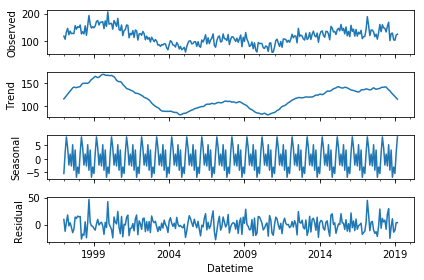

In [6]:
petition_decomp = seasonal_decompose(petition_counts_by_neighborhood_df[good_neighborhoods_list].sum(axis=1), model='additive', extrapolate_trend = True)
petition_decomp.plot();

In [7]:
# Petition Decomp
petition_decomp_df = pd.DataFrame(petition_decomp.observed).reset_index().rename(columns = {0: 'Observed'})
petition_decomp_df = petition_decomp_df.merge(petition_decomp.trend.reset_index(), on = ['Datetime']).rename(columns = {0: 'Trend'})
petition_decomp_df = petition_decomp_df.merge(petition_decomp.seasonal.reset_index(), on = ['Datetime']).rename(columns = {0: 'Seasonal'})
petition_decomp_df = petition_decomp_df.merge(petition_decomp.resid.reset_index(), on = ['Datetime']).rename(columns = {0: 'Resid'})
petition_decomp_df['Sum'] = petition_decomp_df['Trend'] + petition_decomp_df['Seasonal'] + petition_decomp_df['Resid']

seasonal_min = min(petition_decomp_df['Seasonal'])
petition_decomp_df['Adj. Trend'] = petition_decomp_df['Trend'] + seasonal_min
petition_decomp_df['Adj. Seasonal'] = petition_decomp_df['Seasonal'] - seasonal_min
petition_decomp_df['Signal'] = petition_decomp_df['Trend'] + petition_decomp_df['Resid']
petition_decomp_df['Adj. Signal'] = petition_decomp_df['Trend'] + petition_decomp_df['Resid'] + seasonal_min

# Unemployment Decomp

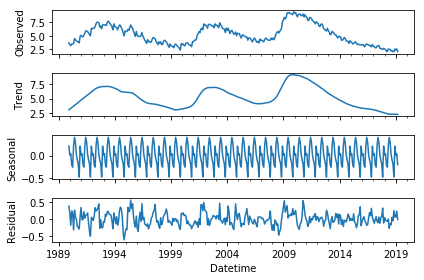

In [8]:
# Unemployment Decomp
unemployment_clean_df = unemployment_df.reset_index()
unemployment_clean_df['Datetime'] = unemployment_clean_df['Datetime'].apply(lambda x: x-dt.timedelta(1))
unemployment_decomp = seasonal_decompose(unemployment_clean_df.set_index('Datetime'), model='additive', extrapolate_trend = True)
unemployment_decomp.plot();

In [9]:
# Unemployment Decomp
unemployment_decomp_df = pd.DataFrame(unemployment_decomp.observed).reset_index().rename(columns = {'Rate': 'Observed'})
unemployment_decomp_df = unemployment_decomp_df.merge(unemployment_decomp.trend.reset_index(), on = ['Datetime']).rename(columns = {'Rate': 'Trend'})
unemployment_decomp_df = unemployment_decomp_df.merge(unemployment_decomp.seasonal.reset_index(), on = ['Datetime']).rename(columns = {'Rate': 'Seasonal'})
unemployment_decomp_df = unemployment_decomp_df.merge(unemployment_decomp.resid.reset_index(), on = ['Datetime']).rename(columns = {'Rate': 'Resid'})

seasonal_min = min(unemployment_decomp_df['Seasonal'])
unemployment_decomp_df['Adj. Trend'] = unemployment_decomp_df['Trend'] + seasonal_min
unemployment_decomp_df['Adj. Seasonal'] = unemployment_decomp_df['Seasonal'] - seasonal_min
unemployment_decomp_df['Signal'] = unemployment_decomp_df['Trend'] + unemployment_decomp_df['Resid']
unemployment_decomp_df['Adj. Signal'] = unemployment_decomp_df['Trend'] + unemployment_decomp_df['Resid'] + seasonal_min 

In [10]:
unemployment_decomp_filtered_df = unemployment_decomp_df[(unemployment_decomp_df['Datetime'] >= min(petition_decomp_df['Datetime']))].reset_index(drop=True)

In [11]:
min(petition_decomp_df['Datetime'])

Timestamp('1997-01-31 00:00:00')

In [12]:
unemployment_df[unemployment_df.index >= min(petition_decomp_df['Datetime'])]

,Rate
Datetime,
1997-02-01,3.9
1997-03-01,4.0
1997-04-01,3.8
1997-05-01,3.9
1997-06-01,4.4
1997-07-01,4.7
1997-08-01,4.6
1997-09-01,4.5
1997-10-01,4.0


Text(0.5,1,'Unemployment Rate vs Petition Volume')

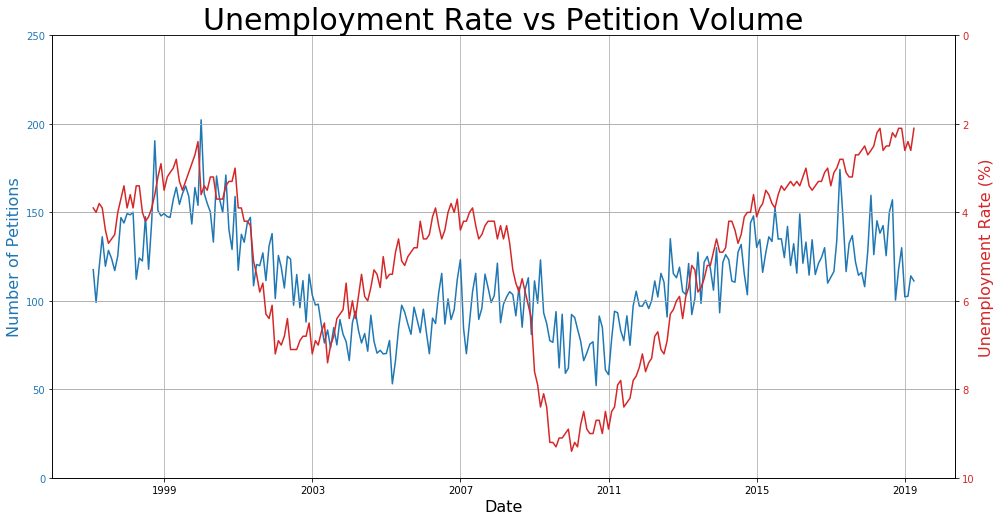

In [13]:
# Create some mock data
t = petition_decomp_df[['Datetime', 'Adj. Signal']].rename(columns = {'Adj. Signal': 'Observed'}).set_index("Datetime").index
data1 = petition_decomp_df[['Datetime', 'Adj. Signal']].rename(columns = {'Adj. Signal': 'Observed'}).set_index("Datetime")
data2 = unemployment_df[unemployment_df.index >= min(petition_decomp_df['Datetime'])]

fig, ax1 = plt.subplots(figsize = (14, 7))

color = 'tab:blue'
ax1.set_xlabel('Date', fontsize = 16)
ax1.set_ylabel('Number of Petitions', color=color, fontsize = 16)
ax1.set_ylim(0, 250)
ax1.plot(t, data1, color=color)
ax1.grid(True)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Unemployment Rate (%)', color=color, fontsize = 16)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.set_ylim(10, 0)
ax2.grid(True)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.grid(True, axis = 'x')
plt.title('Unemployment Rate vs Petition Volume', fontsize = 30)
#plt.savefig('Figures/Unemployment Rate Predictor.png', transparent = True, bbox_inches = 'tight')


# Correlation vs Lag

In [14]:
# Split data
petition_train_df = petition_decomp_df[['Datetime', 'Adj. Signal']][petition_decomp_df['Datetime'] <= dt.datetime(2014, 1, 31)]
petition_test_df = petition_decomp_df[['Datetime', 'Adj. Signal']][petition_decomp_df['Datetime'] > dt.datetime(2014, 1, 31)]

In [15]:
# Split data
unemployment_train_df = unemployment_decomp_filtered_df[['Datetime', 'Adj. Signal']][unemployment_decomp_filtered_df['Datetime'] <= dt.datetime(2014, 1, 31)]
unemployment_test_df = unemployment_decomp_filtered_df[['Datetime', 'Adj. Signal']][unemployment_decomp_filtered_df['Datetime'] > dt.datetime(2014, 1, 31)]

In [16]:
# Unemployment Autocorrelation
corr_list = []
for i in range(0, 13):
    corr_list.append(
        np.corrcoef(
            unemployment_train_df['Adj. Signal'].shift(i).iloc[i:len(unemployment_train_df)],
            petition_train_df['Adj. Signal'].iloc[i:len(petition_train_df)]
        )[0][1]
    )
corr_list

[-0.6208842217371034,
 -0.6325819501565053,
 -0.6420539849825624,
 -0.648086420063459,
 -0.6455072056494529,
 -0.649288912731276,
 -0.6493063379280928,
 -0.6441916385677385,
 -0.6435833257347494,
 -0.6397234398606729,
 -0.6270486889771888,
 -0.6184388318735446,
 -0.6070728152820288]

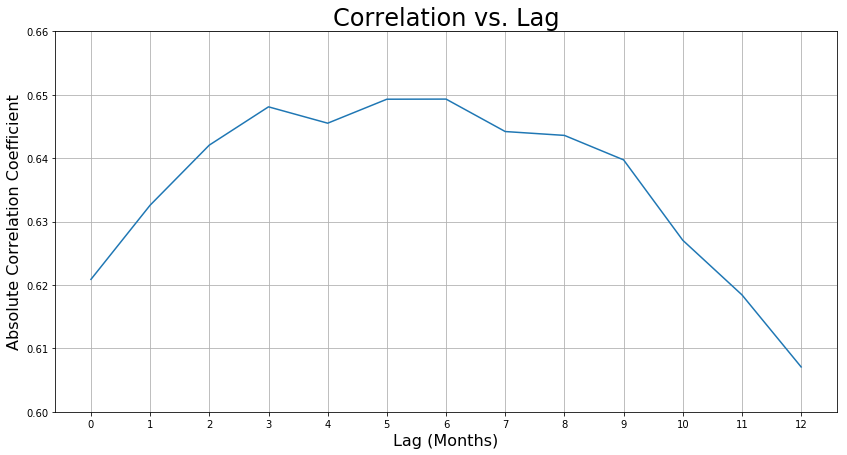

In [17]:
fig, ax = plt.subplots(figsize=(14, 7))
plt.plot(list(map(abs,corr_list)))
plt.title('Correlation vs. Lag', fontsize = 24)
plt.xlabel('Lag (Months)', fontsize = 16)
plt.ylabel('Absolute Correlation Coefficient', fontsize = 16)
plt.xticks(range(0, 13))
plt.ylim(0.6, 0.66)
ax.grid(True)
plt.savefig('Figures/Correlation vs Lag', transparent = True, bbox_inches="tight")
# Lag 3 months is the best

# Linear Regression

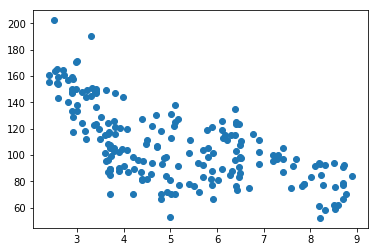

In [18]:
i=3
plt.scatter(unemployment_train_df['Adj. Signal'].shift(i).iloc[i:len(unemployment_train_df)],
     petition_train_df['Adj. Signal'].iloc[i:len(unemployment_train_df)])
plt.show()

In [19]:
# Used for K-fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state = 72)
scaler = StandardScaler()

In [20]:
data_df = pd.DataFrame(unemployment_train_df['Adj. Signal'].shift(i).iloc[i:len(unemployment_train_df)])
data_df = data_df.rename(columns = {'Adj. Signal': 'Unemployment'})
data_df['Petition'] = petition_train_df['Adj. Signal'].iloc[i:len(unemployment_train_df)]

In [21]:
# Scikit Learn's LinearRegression with Log Variables

# Set aside 20% of data for final test
features_train_all_df, features_test_all_df, target_train_ser, target_test_ser = train_test_split(data_df.drop(columns = ['Petition']), data_df['Petition'], test_size=.2, random_state=42)

# Choose features, KFold requires ndarray inputs
features_list = ['Unemployment']

features_train_chosen_df = features_train_all_df[features_list]
features_train_chosen_array = np.array(features_train_chosen_df)
features_test_chosen_df = features_test_all_df[features_list]
features_test_chosen_array = np.array(features_test_chosen_df)
target_train_array = np.array(target_train_ser)
target_test_array = np.array(target_test_ser)

# KFold Cross-Validation
r2_cv_list = [] # Collect the cross-validation results

for train_index, val_cv_index in kf.split(features_train_chosen_array, target_train_array):
    
    # Make the split
    features_train_cv_array, target_train_cv_array = features_train_chosen_array[train_index], target_train_array[train_index]
    features_val_cv_array, target_val_cv_array = features_train_chosen_array[val_cv_index], target_train_array[val_cv_index] 
    
    # Rebalance train features, no need to rebalance validation set, resample is better than smote
    #features_train_cv_scaled_array = scaler.fit_transform(features_train_cv_array)  # Scale resampled features
    #features_val_cv_scaled_array = scaler.transform(features_val_cv_array)  # Scale validation features
    
    ols_model = sm.OLS(target_train_cv_array, sm.add_constant(features_train_cv_array))
    ols_results = ols_model.fit() # Fit model
    
    # Collect results on the validation set
    SSE = sum((target_val_cv_array - ols_results.predict(sm.add_constant(features_val_cv_array)))**2)
    SST = sum((target_val_cv_array - np.mean(target_val_cv_array))**2)
    r2_cv_list.append(1-SSE/SST)

print(r2_cv_list)
print('val_r2_score: ', mean(r2_cv_list),' +/- ', stdev(r2_cv_list))

# Test
#features_train_scaled_array = scaler.fit_transform(features_train_chosen_df)
#features_test_scaled_array = scaler.transform(features_test_chosen_df)

# Fit model
ols_model = sm.OLS(target_train_ser, sm.add_constant(features_train_chosen_df))
ols_results = ols_model.fit()

# Save results for comparison later
OLS_array = ols_results.predict(sm.add_constant(features_test_chosen_df))

# Collect results on the test set
SSE = sum((target_test_ser - OLS_array)**2)
SST = sum((target_test_ser - np.mean(target_test_ser))**2)

print('test_r2_score: ', 1-SSE/SST) #Get score
print(list(ols_results.params[0:2]))

[0.3079729536771967, 0.4384330428407476, 0.4578858163490238, 0.2722658800613207, 0.4709448322226141]
val_r2_score:  0.3895005050301806  +/-  0.09232391539274709
test_r2_score:  0.3771517602333726
[161.37235327506917, -10.563571789773912]


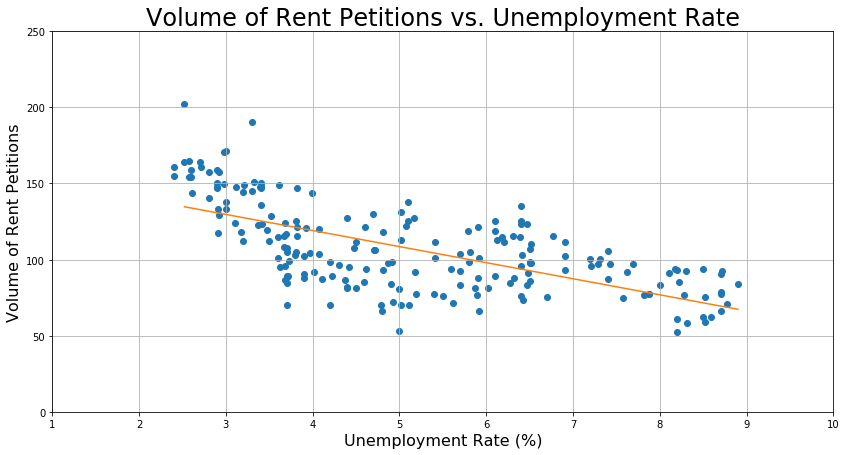

In [22]:
fig, ax = plt.subplots(figsize=(14, 7))
lim_list = [min(features_test_chosen_df.Unemployment), max(features_train_chosen_df.Unemployment)]

ax = plt.scatter(features_test_chosen_df, target_test_ser, color = '#1f77b4', label = None)
ax = plt.scatter(features_train_chosen_df, target_train_ser, color = '#1f77b4', label = None)
ax = plt.plot(lim_list, ols_results.predict(sm.add_constant(lim_list)), color = '#ff7f0e', label = "Fit")

plt.xlim(1, 10)
plt.ylim(0, 250)
plt.title('Volume of Rent Petitions vs. Unemployment Rate', fontsize = 24)
plt.xlabel('Unemployment Rate (%)', fontsize = 16)
plt.ylabel('Volume of Rent Petitions', fontsize = 16)
plt.grid(True)
plt.savefig("Figures/Linear Regression.png", transparent=True, bbox_inches="tight")
plt.show()

# Forecasting Using Linear Regression

In [23]:
# Generating Predictions based on OLS
prediction_df = petition_decomp_df[['Datetime', 'Adj. Trend']]
prediction_df['Predict'] = unemployment_decomp_filtered_df['Adj. Trend'] \
    .apply(lambda x: ols_results.params[0:2][0] + x * ols_results.params[0:2][1]).round().shift(3)

Text(0.5,1,'Forecasted Rent Petitions')

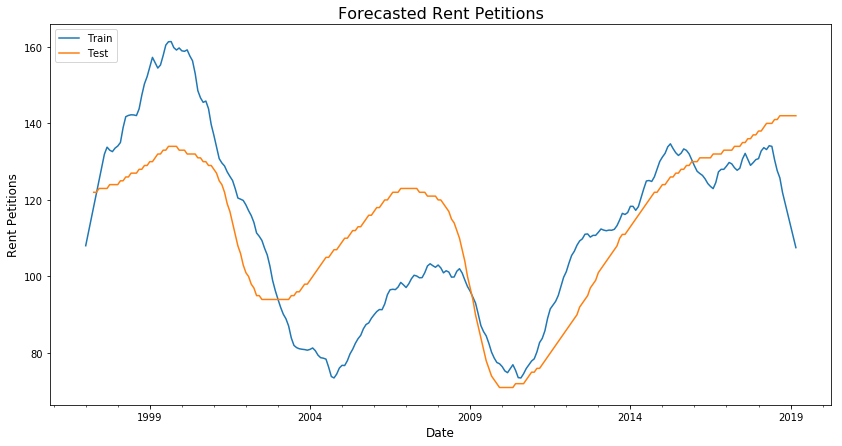

In [24]:
ax = prediction_df[['Datetime', 'Adj. Trend']].rename(columns = {'Adj. Trend': 'Train'}).set_index("Datetime").plot(figsize=(14, 7))
prediction_df[['Datetime', 'Predict']].rename(columns = {'Predict': 'Test'}).set_index("Datetime").plot(ax=ax)

ax.set_xlabel('Date', fontsize = 12)
ax.set_ylabel('Rent Petitions', fontsize = 12)
plt.legend(loc='upper left')
plt.title('Forecasted Rent Petitions', fontsize=16)
#plt.savefig('Figures/Rent Petitions Predictions', transparent = True, bbox_inches = 'tight')

In [25]:
# Generating Predictions based on OLS
prediction_df = petition_decomp_df[['Datetime', 'Adj. Signal']]
prediction_df['Predict'] = unemployment_decomp_filtered_df['Observed'] \
    .apply(lambda x: ols_results.params[0:2][0] + x * ols_results.params[0:2][1]).round().shift(3) \
    + petition_decomp_df['Adj. Seasonal']

In [26]:
# Split data
petition_train_df = petition_decomp_df[['Datetime', 'Adj. Signal']][petition_decomp_df['Datetime'] <= dt.datetime(2014, 1, 31)]
petition_test_df = petition_decomp_df[['Datetime', 'Adj. Signal']][petition_decomp_df['Datetime'] > dt.datetime(2014, 1, 31)]

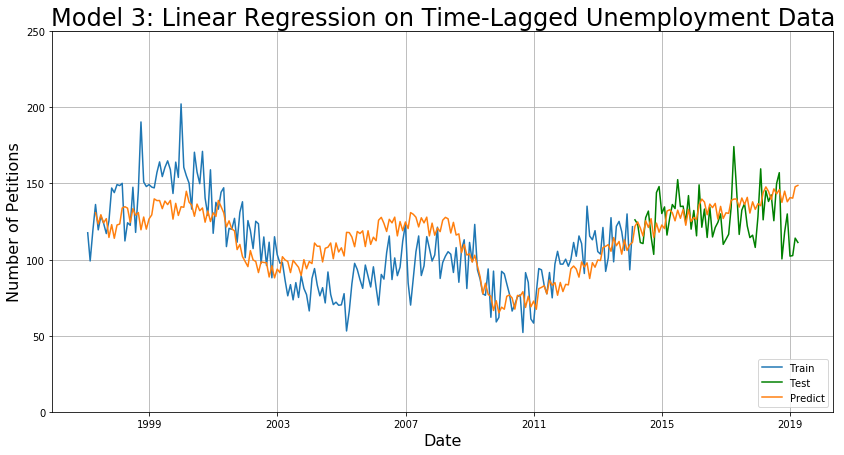

In [27]:
fig, ax = plt.subplots(figsize=(14, 7))
plt.plot(petition_train_df[['Datetime', 'Adj. Signal']].set_index("Datetime"), label = 'Train')
plt.plot(petition_test_df[['Datetime', 'Adj. Signal']].set_index("Datetime"), label = 'Test', color = 'g')
plt.plot(prediction_df[['Datetime', 'Predict']].set_index('Datetime'), label = 'Predict')

plt.ylim(0, 250)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Number of Petitions', fontsize=16)
plt.legend(loc = 'lower right')
ax.grid(True)
plt.title('Model 3: Linear Regression on Time-Lagged Unemployment Data', fontsize=24)
plt.savefig("Figures/Rent Petitions Predictions.png", transparent=True, bbox_inches="tight")

In [28]:
# MAE for 3 months
mean(abs(
    (prediction_df[(prediction_df['Datetime'] > dt.datetime(2014, 1, 31))
              & (prediction_df['Datetime'] <= dt.datetime(2014, 4, 30))]['Adj. Signal']
     -    (prediction_df[(prediction_df['Datetime'] > dt.datetime(2014, 1, 31))
              & (prediction_df['Datetime'] <= dt.datetime(2014, 4, 30))]['Predict']) )
    ))

5.115283267457168

In [29]:
# MAE for 5 years
mean(abs(
    (prediction_df[(prediction_df['Datetime'] > dt.datetime(2014, 1, 31))]['Adj. Signal']
     -    (prediction_df[(prediction_df['Datetime'] > dt.datetime(2014, 1, 31))]['Predict']) )
    ))

13.607394066896179